In [100]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [101]:
public = pd.read_excel('public_housing_physical_inspection_scores_0321.xlsx')
multi = pd.read_excel('multifamily_physical_inspection_scores_0321.xlsx')

In [145]:
multi.groupby(by='ZIPCODE').size().describe()

count    9949.000000
mean        2.755553
std         2.673409
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        41.000000
dtype: float64

In [102]:
# multi = multi[multi.CITY == 'New York']

In [103]:
# multi = multi[multi.STATE_NAME == 'NY']

In [104]:
df = multi.loc[:, ['LATITUDE', 'LONGITUDE', 'INSPECTION_SCORE']]
df = df.rename(columns={'LATITUDE': 'latitude',
                        'LONGITUDE': 'longitude',
                        'INSPECTION_SCORE': 'metric'})

In [105]:
# Filter locations where the metric is low (e.g., below some threshold)
low_metric_threshold = 70
# low_metric_locations = df[df["metric"] < low_metric_threshold]
low_metric_locations = df

In [106]:
low_metric_locations = low_metric_locations.dropna()

In [107]:
len(low_metric_locations)

27415

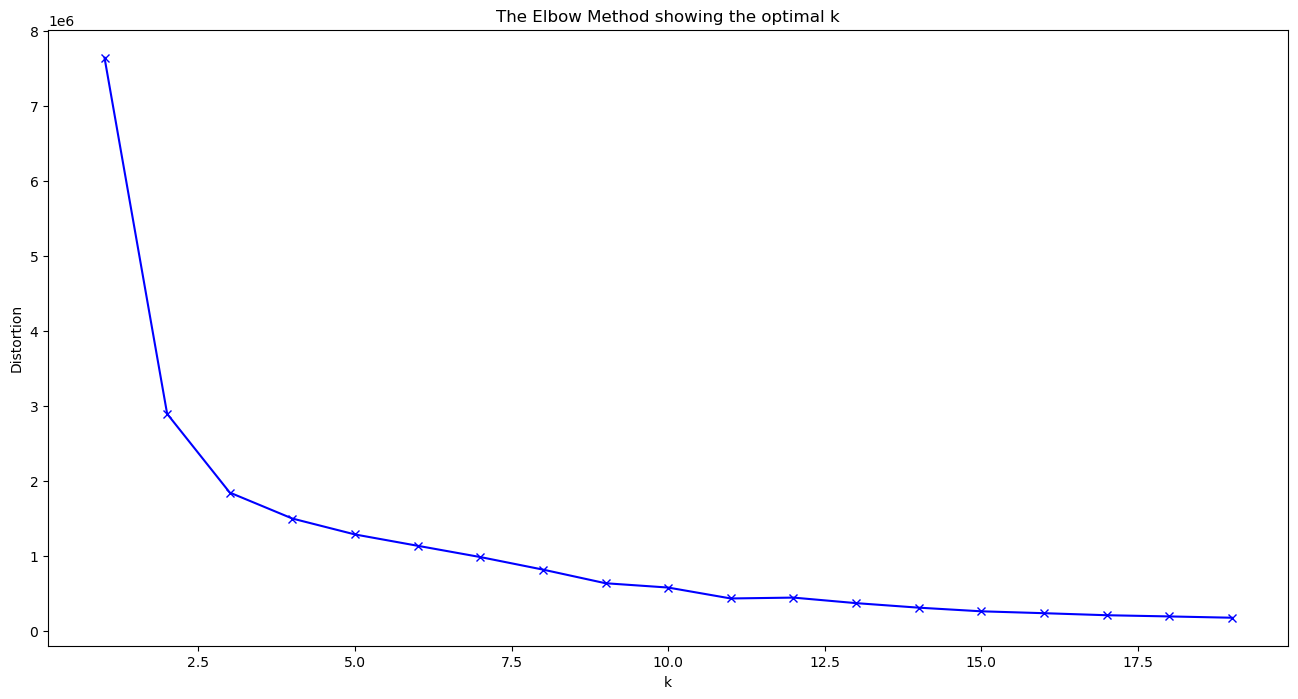

In [108]:
# Find the optimal value for k using the Elbow method
distortions = []
K = range(1, 20)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(low_metric_locations[["latitude", "longitude"]])
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(16, 8))
plt.plot(K, distortions, "bx-")
plt.xlabel("k")
plt.ylabel("Distortion")
plt.title("The Elbow Method showing the optimal k")
plt.show()


In [126]:
# Choose the optimal value of k based on the Elbow method
optimal_k = 150

# Apply KMeans clustering
kmeans = KMeans(n_clusters=optimal_k, n_init='auto')
low_metric_locations["cluster"] = kmeans.fit_predict(low_metric_locations[["latitude", "longitude"]])


C:\Users\jackv\AppData\Local\Temp\ipykernel_8760\3839325908.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_metric_locations["cluster"] = kmeans.fit_predict(low_metric_locations[["latitude", "longitude"]])


In [127]:
low_metric_locations.groupby(by='cluster').metric.mean().sort_values()

cluster
147    74.500000
6      75.200000
70     79.092593
98     79.250000
132    79.294118
         ...    
43     90.561538
60     90.607330
117    91.094737
139    91.207547
115    91.944444
Name: metric, Length: 150, dtype: float64

In [139]:
select_cluster = low_metric_locations[low_metric_locations.cluster == 115]

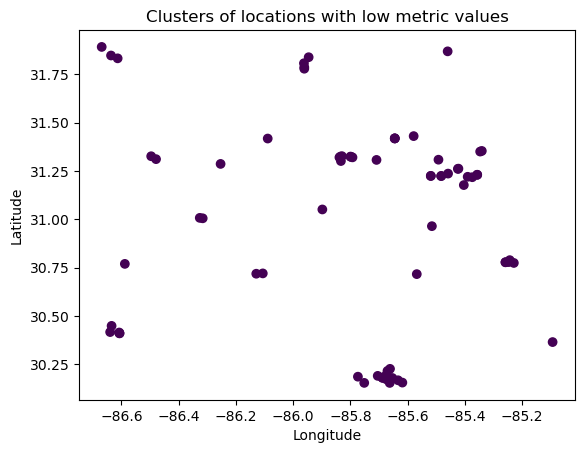

In [140]:
# Plot the clusters
plt.scatter(select_cluster["longitude"], select_cluster["latitude"], c=select_cluster["cluster"], cmap="viridis")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Clusters of locations with low metric values")
plt.show()


In [141]:
import folium

# Create a map centered at the average latitude and longitude of the low_metric_locations
map_center = [select_cluster["latitude"].mean(), select_cluster["longitude"].mean()]
map_clusters = folium.Map(location=map_center, zoom_start=4)

# Define a color scheme for the clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'darkblue', 'darkgreen', 'cadetblue']

# Add the clustered points to the map
for index, row in select_cluster.iterrows():
    latitude, longitude, cluster = row["latitude"], row["longitude"], row["cluster"]
    folium.CircleMarker(
        location=[latitude, longitude],
        radius=5,
        popup=f'Cluster {cluster}',
        fill=True,
        fill_opacity=0.7,
        parse_html=False
    ).add_to(map_clusters)

# Display the map
map_clusters
